# PARAMETERS

In [1]:
# NOTINREPORT
%run ./src/Modules.ipynb   
changeParameters()



button = widgets.Button(description="Save parameters!")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    np.savetxt( './src/parameters.csv',
            [[sampleName_p.value, measureDuration_p.value, Rload_p.value, nbCycles_p.value, Rcircuit_p.value, fourrierMaxFreq_p.value]],
            delimiter=",",
            fmt='%s',
            header = 'Sample name, Measure duration, Rload, Nb Periods, R Circuit, Max Frequency'
            )

button.on_click(on_button_clicked)

Text(value='sdsdsjk;ds', description='Sample name:', placeholder='Custom Name')

Button(description='Save parameters!', style=ButtonStyle())

Output()

In [10]:
### Print parameters
parameters = np.loadtxt('./src/parameters.csv', delimiter=",", comments='#', dtype=str)

sampleName = parameters[0]
measureDuration = float(parameters[1])
Rload = float(parameters[2])
nbCycles = float(parameters[3])
Rcircuit = float(parameters[4])
fourrierMaxFreq = float(parameters[5])

folder = './data/{}/{}_{}/{}/{}h{}/{}/'.format(date.today().strftime('%Y'), date.today().strftime('%m'), date.today().strftime('%B'), date.today().strftime('%d'), str(time.localtime().tm_hour).zfill(2), str(time.localtime().tm_min).zfill(2), sampleName)

print('Sample name: ' + str(sampleName))
print('Duration of measurements: %0.2f [s]' %(previousPowerOf2( int( min( 10, measureDuration )* 125e6 / 16384 )) / 125e6 * 16384 ))
print('Load resistance: %0.2e [Ohms]' %Rload)
print('Circuit resistance: %0.2e [Ohms]' %Rcircuit)
print('Number of periods displayed: %0.0f' %nbCycles)
print('Maximum frequency for analysis: %0.0f [Hz]' %fourrierMaxFreq)

Sample name: klsddsdsdsd
Duration of measurements: 2.15 [s]
Load resistance: 0.00e+00 [Ohms]
Circuit resistance: 0.00e+00 [Ohms]
Number of periods displayed: 0
Maximum frequency for analysis: 0 [Hz]


# PRESSURE AND VOLTAGE MEASUREMENTS

In [11]:
# Perform measurements
# Update the folder with the date/time of the experiment
folder              = './data/{}/{}_{}/{}/{}h{}/{}/'.format(date.today().strftime('%Y'), date.today().strftime('%m'), date.today().strftime('%B'), date.today().strftime('%d'), str(time.localtime().tm_hour).zfill(2), str(time.localtime().tm_min).zfill(2), sampleName)

voltage, pressure   = getRFInputs(measureDuration)                                          # Get data from RedPitaya
pressure.y          /= 2                                                                    # Convert from V to Bar

pressure.FourierTransform(fourrierMaxFreq)                                                  # Perform Fourier transform on pressure
voltage.FourierTransform(fourrierMaxFreq)                                                   # Perform Fourier transform on voltage
print('The input frequency is: {:5.2f} Hz'.format(pressure.getFrequency()))                 # Find excitation frequency and print it

graphVoltage        = graph(    voltage.t,   voltage.y,                                     # Define voltage graph
                                'Time [s]', 'Voltage [V]', 'Piezo output Voltage VS Time')
graphPressure       = graph(    pressure.t, pressure.y,                                     # Define pressure graph
                                'Time [s]', 'Pressure [Bar]', 'Input Pressure VS Time')

plotGraph([graphPressure], [graphVoltage], 'InputOutputFull')                               # Plot graph and save it                              

KeyboardInterrupt: 

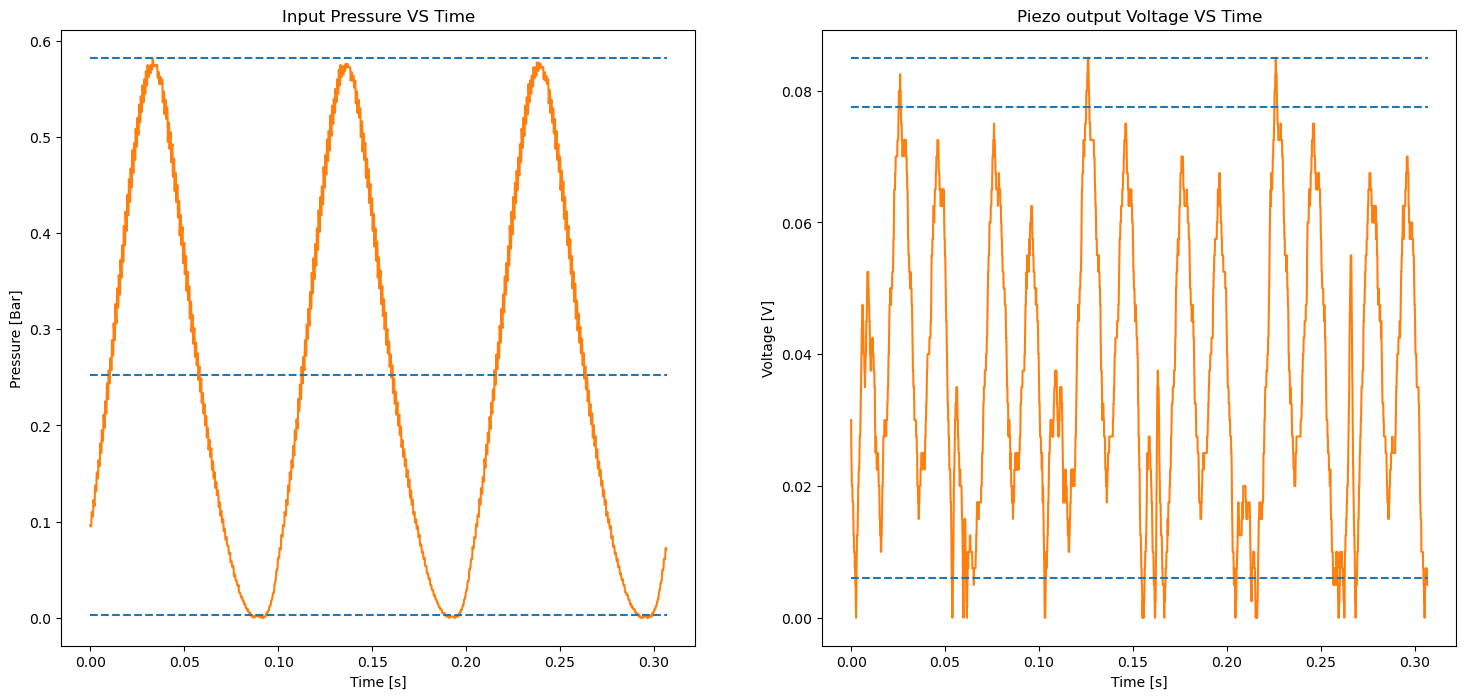

Max pressure: 0.58 [Bar]
Min pressure: -0.00 [Bar]
Peak to peak pressure: 0.58 [Bar]
Mean pressure: 0.25 [Bar]
Max voltage: 0.09 [V]
Min voltage: -0.08 [V]
Peak to peak voltage: 0.16 [V]
Mean voltage: 0.01 [V]


In [50]:
### Plot measurements cropped to the first periods
period, period_sec  = pressure.find_period( nbCycles )                                      # Find the period (index and in sec) of the input

graphVoltageCropped = graph( voltage.t[:period],    voltage.y[:period],                     # Define the cropped voltage graph
                        'Time [s]', 'Voltage [V]',      'Piezo output Voltage VS Time', color='C1')
graphPressureCropped= graph( pressure.t[:period],   pressure.y[:period],                    # Define the cropped pressure graph
                        'Time [s]', 'Pressure [Bar]',   'Input Pressure VS Time',       color='C1')

plotGraph(  [ graphPressureCropped,                                                          # Plot graph with mean value and maxima
            graph([ 0, period_sec ], [ max(pressure.y), max(pressure.y) ],          symbol='--'),
            graph([ 0, period_sec ], [ np.mean(pressure.y), np.mean(pressure.y) ],  symbol='--'),
            graph([ 0, period_sec ], [ min(pressure.y), min(pressure.y) ],          symbol='--')],
            [ graphVoltageCropped,
            graph([ 0, period_sec ], [ max(voltage.y), max(voltage.y) ],            symbol='--'),
            graph([ 0, period_sec ], [ np.mean(voltage.y), np.mean(voltage.y)],     symbol='--'),
            graph([ 0, period_sec ], [ min(voltage.y), min(voltage.y) ],            symbol='--')],
            'InputOutput{}periods'.format(nbCycles))

### Print the relevant indicators
print('Max pressure: %0.2f [Bar]' %( np.max(pressure.y) ))
print('Min pressure: %0.2f [Bar]' %( np.min(pressure.y) ))
print('Peak to peak pressure: %0.2f [Bar]' %( np.max(pressure.y) - np.min(pressure.y) ))
print('Mean pressure: %0.2f [Bar]' %( np.mean(pressure.y) ))
print('Max voltage: %0.2f [V]' %( np.max(voltage.y) ))
print('Min voltage: %0.2f [V]' %( np.min(voltage.y) ))
print('Peak to peak voltage: %0.2f [V]' %( np.max(voltage.y) - np.min(voltage.y) ))
print('Mean voltage: %0.2f [V]' %(np.mean(voltage.y)))

# PRESSURE DERIVARTIVE

In [43]:
### Plot the denoised input pressure and its derivative
pressureDN          = data( pressure.t[ : 2*period ], pressure.y[ : 2*period ] )            # Define a new data object for pressure cropped
pressureDN          = pressureDN.Denoise( 1000 )                                             # Denoise it using splines
pressureDN_dt       = np.gradient( pressureDN.y, pressureDN.t, axis=0, edge_order=2 )       # Compute time derivative

graphPressureDN     = graph( pressureDN.t, pressureDN.y,                                    # Define denoised pressure graph
                            'Time [s]', 'Pressure [Bar]', 'Denoised Input Pressure VS Time')
graphPressure_dt    = graph( pressureDN.t, pressureDN_dt,                                   # Define pressure time derivative graph         
                            'Time [s]', 'Pressure Derivative [Bar/s]', 'Input Pressure Time derivative')

plotGraph([ graphPressureDN ], [ graphPressure_dt ], 'PressureTimeDerivative')              # Plot graph and save it

NameError: name 'pressure' is not defined

# POWER

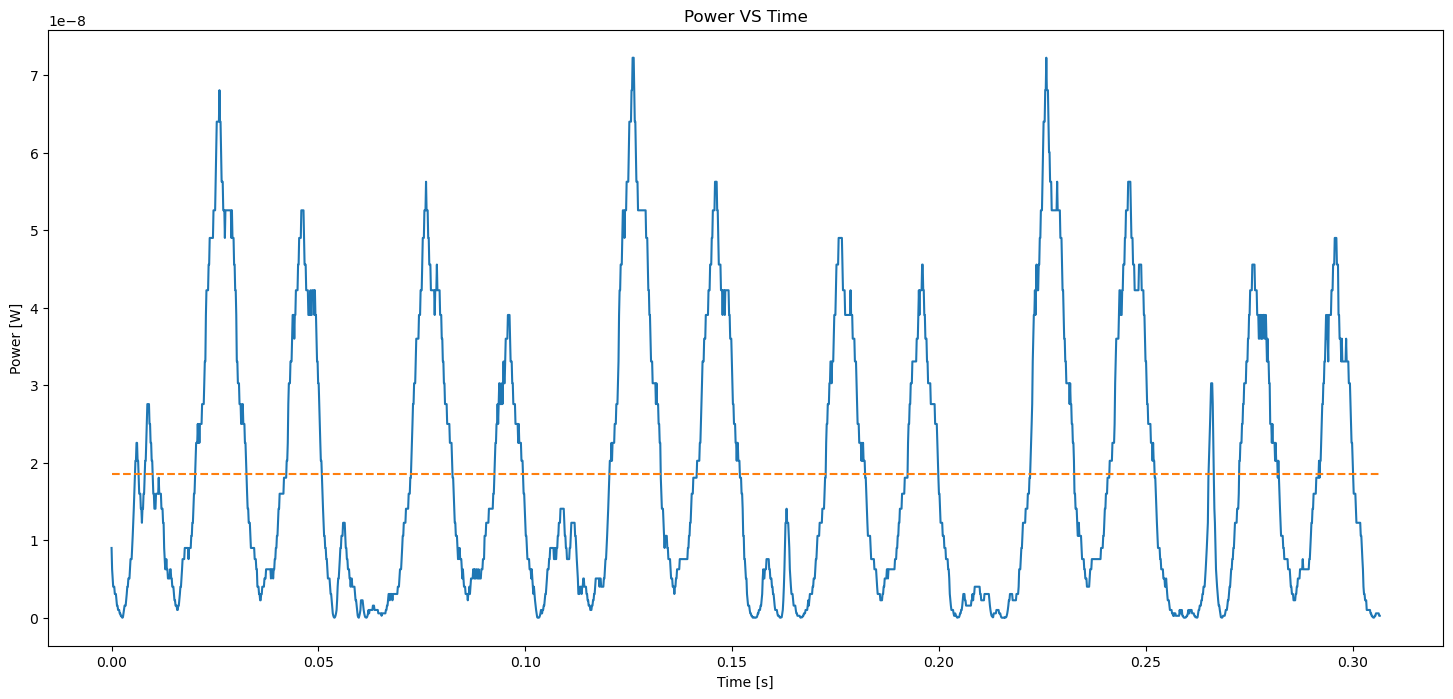

Mean power: 1.85e-08 [W]


In [52]:
### Compute power using Ohm's law
power               = data( voltage.t[ : period ], voltage.y[ : period ] ** 2 / ( Rload + Rcircuit ))   

graphPower          = graph( power.t, power.y, 'Time [s]', 'Power [W]', 'Power VS Time' )   # Define power graph
graphPowerAverage   = graph( [ 0, np.max(power.t) ], [ np.mean(power.y), np.mean(power.y) ], symbol='--', color='C1')

plotGraph([ graphPower, graphPowerAverage ], None, 'Power')                                 # Plot graph and save it

print('Mean power: %0.2e [W]'%(np.mean(power.y)))                                           # Print mean value

# FREQUENCY ANALYSIS

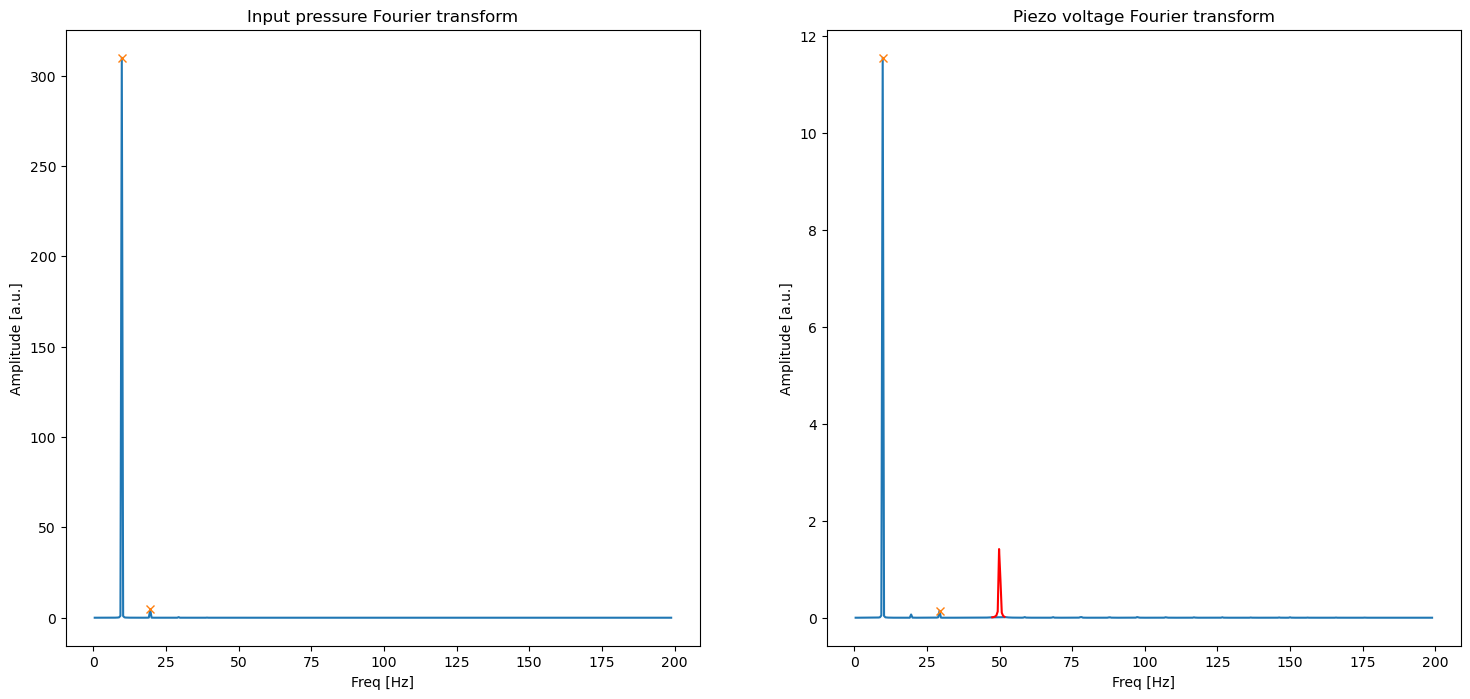

In [53]:
### Plot input pressure and piezo voltage in the frequency domain 
### Find peaks on the Fourier transform
voltagePeaks        = signal.find_peaks( np.real(voltage.ampFT), prominence=max( np.real(voltage.ampFT) ) / 100, distance = 5 )[0]
pressurePeaks       = signal.find_peaks( np.real(pressure.ampFT), prominence=max( np.real(pressure.ampFT )) / 100, distance = 5)[0]

### Extract the peak around 50Hz and delete it
Peak50              = find_nearest( voltagePeaks, find_nearest(voltage.freq, 50) )
Hz50                = voltagePeaks[ Peak50 ]
voltagePeaks        = np.delete( voltagePeaks, Peak50 )

### Define the graphs with a different color around the 50Hz peak
graphVoltageFT      = graph( np.concatenate((voltage.freq[:Hz50-5], voltage.freq[Hz50+5:])), np.conjugate(np.concatenate((voltage.ampFT[:Hz50-5],voltage.ampFT[Hz50+5:]))),
                            'Freq [Hz]', 'Amplitude [a.u.]', 'Piezo voltage Fourier transform')
graphVoltageFTHz50  = graph( voltage.freq[Hz50-5:Hz50+5], np.conjugate(voltage.ampFT[Hz50-5:Hz50+5]),
                            'Freq [Hz]', 'Amplitude [a.u.]', color='r')
graphPressureFT     = graph(pressure.freq, pressure.ampFT,
                            'Freq [Hz]', 'Amplitude [a.u.]', 'Input pressure Fourier transform')

### Define dots
graphVoltagePeaks   = graph(voltage.freq[voltagePeaks], voltage.ampFT[voltagePeaks], symbol='x', color='C1')

graphPressurePeaks  = graph(pressure.freq[pressurePeaks], pressure.ampFT[pressurePeaks], symbol='x', color='C1')

### Plot graph and save it
plotGraph([graphPressureFT, graphPressurePeaks], [graphVoltageFT, graphVoltageFTHz50, graphVoltagePeaks], 'FourierTransform')

In [2]:
### Print table

In [54]:
### Save files
if os.path.exists(folder+sampleName+'.data.csv') or os.path.exists(folder+sampleName+'.report.pdf'):
    raise NameError('Files {} or {} already exist in folder {}, please change sample name!'.format(sampleName+'.data.csv',sampleName+'.report.pdf', folder, ))
else:
    saveNotebook()
    exportData = [pressure.t, pressure.y, voltage.y]
    exportHeader = "t [s], pressure [Bar], voltage [V]"
    %run ./src/SaveFiles.ipynb